In [10]:
pip install peptides

You should consider upgrading via the '/opt/anaconda3/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
#import libraries
import h5py
import numpy
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
import pandas as pd
import peptides
import matplotlib.pyplot as plt
import time
import re

In [51]:
#matching embedding with Gene name in pooled embeddings in the case of all unique sequences

def substrate_match(long_df, descriptors, smiles):
    subs_descpitors = numpy.empty(descriptors.shape[1])
    for item in long_df['Substrate']:
        #print(item)
        index = smiles.index[smiles["Substrate"]==item][0]
        subs_descpitors = numpy.vstack((subs_descpitors, descriptors[index]))
    subs_descpitors = subs_descpitors[1:]
    return subs_descpitors
#function for substrate embedding generation
def substrate_descriptor(smiles, dimension):
    substrate_desc = {}
    for item in dimension:
        substrate_desc[item] = numpy.empty(dimension[item])
    for item in smiles['SMILES']:
        #print(item.index())
        mol = Chem.MolFromSmiles(item)
        models = {'MACCS': Chem.MACCSkeys.GenMACCSKeys(mol)}
        for model in models:
            fp = models[model]
            array = numpy.zeros((0, ), dtype=numpy.int8)
            DataStructs.ConvertToNumpyArray(fp, array)
            substrate_desc[model] = numpy.vstack((substrate_desc[model], array))
    for item in substrate_desc:
        substrate_desc[item]= substrate_desc[item][1:]
    return substrate_desc
def model_score(score):
    mean_scores = dict()
    for item in score:
        print(item)
        metr = list()
        sd = list()
        for value in score[item]:
            metr.extend(mean(value, axis =0 ))
            sd.extend(numpy.std(value, axis = 0))
        mean_scores[item] = [metr, sd]
    return mean_scores

def seq_desc_match(descriptor_dict, seq_index, long_df):
    start_time = time.perf_counter()
    x = list(descriptor_dict.keys())[0]    
    seq_embeddings = numpy.empty(len(descriptor_dict[x]))
    for item in long_df["Gene"]:
        array = descriptor_dict[seq_index[seq_index.index(item)]]
        #removinf nans
        #array = numpy.nan_to_num(array, nan=0.0)
        seq_embeddings = numpy.vstack((seq_embeddings,array))
    seq_embeddings = seq_embeddings[1:]
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print("Elapsed time: ", elapsed_time)
    return seq_embeddings 

#function to convert url
def convert_google_sheet_url(url):
    # Regular expression to match and capture the necessary part of the URL
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'

    # Replace function to construct the new URL for CSV export
    # If gid is present in the URL, it includes it in the export URL, otherwise, it's omitted
    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=csv'

    # Replace using regex
    new_url = re.sub(pattern, replacement, url)

    return new_url

#make msa df 
def make_msa_df(align, input_dict, type_str, drop):
    msa_df = pd.DataFrame()
    name_align = type_str + "_alignment"
    name_res = type_str + "_residue"
    for item in input_dict[name_align]:
        x = list()
        for letter in str(align[:, item]):
            x.append(letter)
        msa_df[input_dict[name_res][input_dict[name_align].index(item)]] = x
    #dropping identical columns 
    if drop == True:
        column_to_drop = list()
        for item in msa_df:
            unique = msa_df[item].unique()
            if len(unique) == 1:
                column_to_drop.append(item)
        msa_df = msa_df.drop(column_to_drop, axis = 1)
    return msa_df
#calculating descriptors based on msa
def make_descriptor_df(input_df):
    descriptors_df = pd.DataFrame()
    for item in input_df:
        desc_list = list()
        for residue in input_df[item]:
            if residue == "-":
                desc_list.append([0] * 88)
            else:
                peptide = peptides.Peptide(residue)
                desc_list.append(list(peptide.descriptors().values()))
        desc_df = pd.DataFrame(desc_list)
        descriptors_df = pd.concat([descriptors_df, desc_df],axis=1)
    return descriptors_df
    
#function to plot all 5 metrics from model_score function
def plot_model_score(score_model):
    metrics_list = ["Accuracy", "ROC AUC", "Precision", "Recall", "F1"]
    x = numpy.arange(len(metrics_list))  # the label locations
    width = 0.5  # the width of the bars
    fig, ax = subplots(figsize = (8,8))
    multiplier = 0
    ax.bar(x, score_model[0], width, yerr = score_model[1])
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_list, rotation=-90)
    ax.legend()
    ax.set_ylim(0.5, 1)

In [3]:
#reading selected residues
url = 'https://docs.google.com/spreadsheets/d/1xjDpF3Br4uu9Wl6GOFFLyqcCiWFvIrH6gLGXaPVd6b4/edit?usp=sharing'
new_url = convert_google_sheet_url(url)
oras_df = pd.read_csv(new_url)

In [5]:
#loading sequences for fungal enzymes and making msa with oras
#alignment is done using ClustalW website
from Bio import AlignIO
align = AlignIO.read("../input_data/T3PKS_alignment_clustal", "clustal")
#indexing names
seq_indexes = list()
for record in align:
    seq_indexes.append(record.id)
#indexing ORAS sequences in the alignment
index_list = dict()
for item in ["ORAS", "MsCHS"]:
    x = str(align[seq_indexes.index(item)].seq)
    index_seq = list()
    i = 1
    for letter in x:
        if letter != "-":
            index_seq.append(i)
            i += 1
        else:
            index_seq.append(0)
    index_list[item] = index_seq

In [6]:
#indexing and creating dictionary for ORAS position in the seq, in the alignment and residue 
#converting google sheet data to a dictionary with position numbers and one-letter codes
from Bio.SeqUtils import seq1
import math
oras_residues = dict()
for item in oras_df:
    enzyme = item.split("_")[0]
    res_list, num_list, align_pos = list(), list(), list()
    for residue in oras_df[item]:
        if isinstance(residue, float) == False:
            res = seq1(residue.split(" ")[1])
            pos = residue.split(" ")[0]
            num_list.append(int(pos))
            res_list.append(res+pos) 
            align_pos.append(index_list[enzyme].index(int(pos)))
    name1 = item + "_position"
    oras_residues[name1] = num_list
    name2 = item + "_residue"
    oras_residues[name2] = res_list
    name3 = item + "_alignment"
    oras_residues[name3] = align_pos

In [7]:
#combining MsCHS_6A_Cys_and_6A_naringenin and ORAS_5A_eicosanoic_acid (cavity and tunnel) residues
tunnel_cavity_alignment = oras_residues["ORAS_5A_eicosanoic_acid_alignment"] + oras_residues['MsCHS_6A_Cys_and_6A_naringenin_alignment']
tunnel_cavity_alignment.sort()
tunnel_cavity_alignment = list(dict.fromkeys(tunnel_cavity_alignment))
print(tunnel_cavity_alignment)
#making list based on ORAS sequence
x = str(align[seq_indexes.index("ORAS")].seq)
index_seq = list()
#pdb 3EUT has nummeration starting with 10, so numbering is offset
i = 0
j = 0
tunnel_cavity_residue, tunnel_cavity_position = list(), list()
for letter in x:
    if letter != "-":
        i += 1
    if j in tunnel_cavity_alignment:
        res_name = letter + str(i)
        tunnel_cavity_residue.append(res_name)
        tunnel_cavity_position.append(i)
    j += 1
oras_residues["tunnel_cavity_alignment"] = tunnel_cavity_alignment
oras_residues["tunnel_cavity_residue"] = tunnel_cavity_residue
oras_residues["tunnel_cavity_position"] = tunnel_cavity_position

[45, 49, 50, 53, 83, 85, 86, 87, 88, 93, 95, 98, 154, 155, 191, 192, 193, 194, 195, 196, 197, 225, 226, 227, 228, 229, 230, 231, 234, 250, 251, 254, 255, 256, 257, 310, 311, 312, 313, 319, 320, 321, 322, 375, 377, 408, 409, 410, 411, 451, 452, 453, 454]


In [9]:
msa, msa_to_plot = dict(), dict()
names = list(oras_df.columns) + ["tunnel_cavity"]
for item in names:
    msa[item] = make_msa_df(align, oras_residues, item, True)
    msa_to_plot[item] = make_msa_df(align, oras_residues, item, False)
msa_descriptors = dict()
for item in msa:
    msa_descriptors[item] = make_descriptor_df(msa[item])


In [10]:
#making dictionary using seq_index for gene name and row from descriptor_df for descriptor
descriptors = dict()
for sets in msa_descriptors:
    descriptors[sets] = dict()
    for item in seq_indexes:
        descriptors[sets][item] = msa_descriptors[sets].loc[seq_indexes.index(item)].values

In [21]:
#reading long_df for prediction and making enzyme/substrate descriptors as previously
long_df = pd.read_csv("../input_data/T3PKS_cellfree_df.csv")
long_df.head()
dimension = {'MACCS': 167}
smiles = pd.read_csv("../input_data/smiles_combined.csv")
fingerprints = substrate_descriptor(smiles,  dimension)


substrate_fp = dict()

for key in fingerprints:
    substrate_fp[key] = substrate_match(long_df, fingerprints[key], smiles)
embeddings = dict()
embeddings['tunnel_cavity'] = seq_desc_match(descriptors['tunnel_cavity'],seq_indexes, long_df)
#concatenating input descriptors
X = dict()
X['MACCS/tunnel_cavity'] =numpy.hstack((embeddings['tunnel_cavity'],  substrate_fp['MACCS']))

Elapsed time:  0.0970971249998911


In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from numpy import  mean, array

#from mpl_toolkits import mplot3d
from matplotlib.pyplot import subplots, axes, scatter, xticks
RANDOM_STATE = 12345

classifiers = {'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE)}

In [24]:
#testing substrate, enzyme, and combined descriptors as an input
RANDOM_STATE  = 12345

y_train = long_df['value']
importances_all = dict()
score_all = dict()
for item in X:
    sss = StratifiedShuffleSplit(random_state=RANDOM_STATE, n_splits=100, test_size=0.3)
    score, roc_auc, precision, recall, f1 = list(), list(),list(),list(), list()
    importances = list()
    
    for train_index, test_index in sss.split(X[item], y_train):
        X_s, y_s = X[item][train_index, :], y_train[train_index]
        new_obs_s, y_test_s = X[item][test_index, :], y_train[test_index]
        score_clf, roc_auc_clf, precision_clf, recall_clf, f1_clf = list(), list(),list(),list(), list()
        importances_clf = list()
        for name, clf in classifiers.items():
            clf.fit(X_s, y_s)
            y_pred_prob = clf.predict_proba(new_obs_s)[:, 1]
            y_pred = clf.predict(new_obs_s)
            score_clf.append(clf.score(new_obs_s, y_test_s))
            roc_auc_clf.append(roc_auc_score(y_test_s, y_pred_prob))
            precision_clf.append(precision_score(y_test_s, y_pred))
            recall_clf.append(recall_score(y_test_s, y_pred))
            f1_clf.append(f1_score(y_test_s, y_pred))
            importances_clf.append(clf.fit(X_s, y_s).feature_importances_)
        score.append(score_clf), 
        roc_auc.append(roc_auc_clf)
        recall.append(recall_clf)
        precision.append(precision_clf)
        f1.append(f1_clf)
        importances.append(importances_clf)

    score_all[item] = (score,roc_auc, precision, recall, f1)
    importances_all[item] = importances
mean_model_scores = model_score(score_all)

MACCS/tunnel_cavity


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


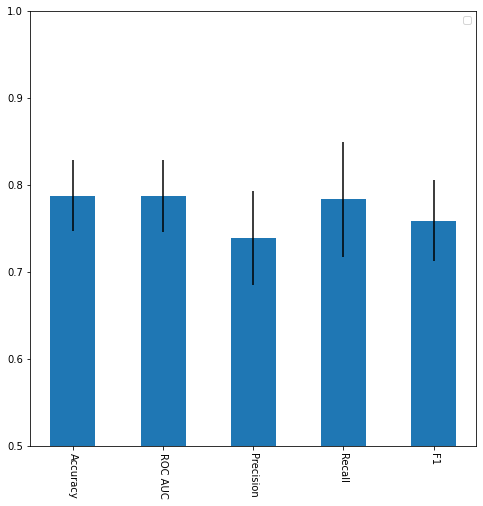

In [52]:
plot_model_score(mean_model_scores['MACCS/tunnel_cavity'])

In [35]:
#writing resuts
metrics_list = ["Accuracy", "ROC AUC", "Precision", "Recall", "F1"]
scores = dict()
for i in range(0,5):
    flat_list = list()
    for item in score_all['MACCS/tunnel_cavity'][i]:
        flat_list.extend(item)
    scores[metrics_list[i]] = flat_list
scores = pd.DataFrame(scores)
scores.to_csv("../output_data/decision_tree_score.csv", sep = ";")

In [59]:
#combining importances by residues 
classifiers.keys()
importance_by_residues = dict()
for item in importances_all:
    name = item.split("/")[1]
    imp_by_split = list()
    for item2 in importances_all[item]:
        imp_by_model = list()
        for item3 in item2:
            combined_values = list()
            count = 0
            for i in range(0, msa[name].shape[1]):
                combined_values.append(sum(item3[count:count+87]))
                count += 88
            imp_by_model.append(combined_values)        
        imp_by_split.append(imp_by_model)
    importance_by_residues[item] = imp_by_split
#rearranging array for boxplot
boxplot_array = list()
for item in importance_by_residues["MACCS/tunnel_cavity"]:
    a = item[0]
    boxplot_array.append(a)
boxplot_array = numpy.array(boxplot_array)

<function matplotlib.pyplot.show(close=None, block=None)>

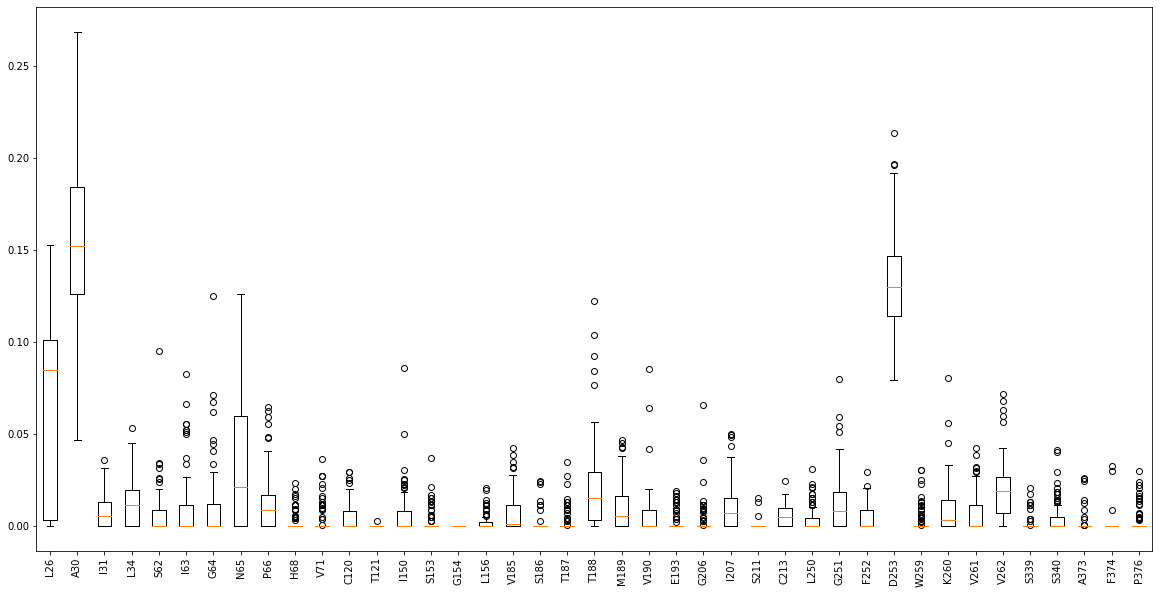

In [58]:
fig, ax = subplots(ncols=1, figsize=(20, 10))
label_ticks =msa['tunnel_cavity'].columns
ax.boxplot(boxplot_array, showfliers=True)
ax.set_xticks(ticks=range(1,msa['tunnel_cavity'].shape[1]+1), labels=label_ticks, rotation='vertical')
plt.show

In [61]:
#export data for importances
box_df = pd.DataFrame(boxplot_array, columns= msa['tunnel_cavity'].columns)
box_df.to_csv("../output_data/importances.csv")

In [62]:
#use Decision tree model importances and import them onto pdb file
#Median from violin/box plot 
MACCS_ligand_cys = pd.DataFrame()
MACCS_ligand_cys['Residue'] = msa['tunnel_cavity'].columns
MACCS_ligand_cys['Importance'] = list(box_df.median(axis = 0))

msa_position = list()
for item in MACCS_ligand_cys['Residue']:
    msa_position.append(oras_residues['tunnel_cavity_alignment'][oras_residues['tunnel_cavity_residue'].index(item)])

MACCS_ligand_cys['MSA'] = msa_position
MACCS_ligand_cys.head()

,Residue,Importance,MSA
0,L26,0.084631,45
1,A30,0.152253,49
2,I31,0.005519,50
3,L34,0.011438,53
4,S62,0.000000,85


In [64]:
#writing msa file for plotting
msa_df = pd.DataFrame(msa['tunnel_cavity'])
msa_df.index = seq_indexes
msa_df = msa_df.T
msa_df.insert(0, "Importance", list(MACCS_ligand_cys['Importance']))
msa_df.to_csv("../output_data/msa_ligand_cys.csv", sep = ",")

In [66]:
#indexing ORAS sequences in the alignment and making sequence number for other enzymes

for item in seq_indexes:
    x = str(align[seq_indexes.index(item)].seq)
    index_list = list()
    i = 1
    count = 0
    seq = list()
    for letter in x:
        if count in MACCS_ligand_cys['MSA'].values:
            if letter != "-":
                seq.append(str(i))
            else:
                seq.append('-')
        if letter != "-":
            i += 1
        count += 1
    MACCS_ligand_cys[item] = seq 
MACCS_ligand_cys.to_csv("../output_data/important_residues.csv", sep = ";")

In [548]:
#take the importance score and write in AF2 predictions
#ORAS structure is 3EUTA
from math import log
from Bio import PDB
from Bio.SeqUtils import seq1
from Bio.PDB.PDBIO import PDBIO
#writing epitopes from selected epitope df using AF2 models
parser = PDB.PDBParser(PERMISSIVE=1)
io = PDBIO()

for item in MACCS_ligand_cys.iloc[:,3:]:
    structure_id = item
    filename = "../input_data/AF_pred/" + item + ".pdb"
    structure = parser.get_structure(structure_id, filename)
    residues = structure.get_residues()
    bfact_list = list()
    for residue in residues:
        res_num = str(residue.get_id()[1])
        #print(res_num)
        res_name = residue.get_resname()
        #res_id = seq1(res_name) + str(res_num)
        if res_num in MACCS_ligand_cys[item].unique():
            if MACCS_ligand_cys['Importance'].loc[MACCS_ligand_cys[item] == res_num].values[0] != 0:
                for atom in residue:
                    #scale b factor by factor 1000 and log for better visibility
                    atom.set_bfactor(log(1000*MACCS_ligand_cys['Importance'].loc[MACCS_ligand_cys[item] == res_num].values[0],10))
            else:
                for atom in residue:
                    atom.set_bfactor(0)
        else:
            for atom in residue:
                atom.set_bfactor(0)

    io.set_structure(structure)
    file_out = "../output_data/AF_pred/residue_importance/" + item + "_importance.pdb"
    io.save(file_out)